## Predict if a candy is chocolate or not based on its other features


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/Pytorch/Dataset/datasets_3732_5912_candy-data.csv')

In [60]:
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [61]:
df.shape

(85, 13)

In [62]:
df.isnull().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

In [63]:
inputs=df.drop(['competitorname','chocolate'],axis=1)
inputs.head()

,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [64]:
target = df[['chocolate']]
target.head()

,chocolate
0,1
1,1
2,0
3,0
4,0


## Getting the values and Converting to Pytorch Tensor

In [0]:
inputs = inputs.values
target = target.values

In [66]:
print(inputs.shape)
print(target.shape)

(85, 11)
(85, 1)


In [67]:
inputs.shape[0]

85

In [0]:
py_inputs = torch.tensor(inputs,dtype=torch.float32)
py_targets = torch.tensor(target ,dtype=torch.float32)

## Building Tensor dataset and Data spliting 

In [0]:
dataset = TensorDataset(py_inputs,py_targets)

In [0]:
val_percent = 0.1 
num_rows = inputs.shape[0]
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [0]:
batchsize = 15

In [0]:
train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_ds , batch_size= batchsize)

In [73]:
for xb,yb in train_loader:
  print("Inputs",xb)
  print("Outputs",yb)
  break

Inputs tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 6.9000e-02, 1.1600e-01, 5.9864e+01],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.0400e-01, 3.2500e-01, 3.4518e+01],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 7.3200e-01, 8.6000e-01, 6.6972e+01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 1.5100e-01, 2.2000e-01, 6.7038e+01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 9.3000e-02, 5.1100e-01, 2.8127e+01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 4.6000e-02, 3.2500e-01, 2.4525e+01],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
      

## Building Model

In [0]:
input_size = 11
num_classes = 1
threshold = 0.5

In [0]:
class Halloween(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size,num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self,xb):
    out = self.sigmoid(self.linear(xb))
    return out

  def training_step(self,batch):
    inputs,target = batch
    out = self(inputs)
    loss = F.binary_cross_entropy(out,target)
    return loss

  def validation_step(self,batch):
    inputs,target = batch
    out = self(inputs)
    loss = F.binary_cross_entropy(out,target)
    acc = accuracy(out,target)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [0]:
model = Halloween()

In [0]:
def accuracy(out, labels):
    return torch.tensor(torch.sum(abs(out-labels) < threshold).item() / len(out))

In [0]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
          loss = model.training_step(batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Training and evaluation

In [80]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 4.8400, val_acc: 0.2500
Epoch [1], val_loss: 0.9510, val_acc: 0.2500
Epoch [2], val_loss: 0.6240, val_acc: 0.7500
Epoch [3], val_loss: 0.6278, val_acc: 0.8750
Epoch [4], val_loss: 0.6055, val_acc: 0.7500
Epoch [5], val_loss: 0.6503, val_acc: 0.6250
Epoch [6], val_loss: 0.6519, val_acc: 0.6250
Epoch [7], val_loss: 1.0060, val_acc: 0.2500
Epoch [8], val_loss: 0.6643, val_acc: 0.6250
Epoch [9], val_loss: 0.6506, val_acc: 0.7500


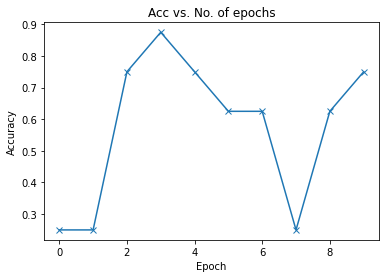

In [81]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Acc vs. No. of epochs');

In [82]:
evaluate(model,val_loader)

{'val_acc': 0.75, 'val_loss': 0.6506310105323792}

## Prediction 


In [0]:
def predict_single(model,input,target):
  inputs = input.unsqueeze(0)
  predictions = model(inputs)
  prediction = predictions[0].detach()
  pr = (prediction[0]>0.5)
  print("Input:", input)
  print("Target:", target)
  print("Prediction:", pr)

In [84]:
input,target=val_ds[0]
predict_single(model,input, target)

Input: tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.3130,  0.2550, 47.1732])
Target: tensor([0.])
Prediction: tensor(False)




```
## This is  a small dataset only to show the implementaion of logistic regression
```

